<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/04_Intro_to_Time_Series_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art **time series regression** model using **`fastai`** and **`tsai`**.

A time series regression is a task in which you assign a continuous value to a univariate or multivariate time series. 

## Import libraries 📚

In [1]:
# ## NOTE: UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI
# stable = False # True: latest version from github, False: stable version in pip
# if stable: 
#     !pip install -Uqq tsai
# else:      
#     !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

# ## NOTE: REMEMBER TO RESTART YOUR RUNTIME ONCE THE INSTALLATION IS FINISHED

     |████████████████████████████████| 194kB 12.1MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 5.7MB 53.6MB/s 
     |████████████████████████████████| 9.5MB 52.3MB/s 
     |████████████████████████████████| 3.2MB 48.9MB/s 
     |████████████████████████████████| 2.5MB 48.4MB/s 
     |████████████████████████████████| 174kB 64.6MB/s 
     |████████████████████████████████| 901kB 62.1MB/s 
     |████████████████████████████████| 92kB 13.9MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 25.3MB 119kB/s 
     |████████████████████████████████| 675kB 46.5MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 


In [2]:
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.0+cu101


## Prepare data 🔢

We are going to select a dataset from the recently released Monash, UEA & UCR 
Time Series Extrinsic Regression Repository (2020) ([web](http://tseregression.org), [paper](https://arxiv.org/abs/2006.10996)). 

Please, feel free to select any other dataset to experiment with it. Here's the entire list.

In [72]:
regression_list

['AppliancesEnergy',
 'AustraliaRainfall',
 'BeijingPM10Quality',
 'BeijingPM25Quality',
 'BenzeneConcentration',
 'Covid3Month',
 'FloodModeling1',
 'FloodModeling2',
 'FloodModeling3',
 'HouseholdPowerConsumption1',
 'HouseholdPowerConsumption2',
 'IEEEPPG',
 'LiveFuelMoistureContent',
 'NewsHeadlineSentiment',
 'NewsTitleSentiment']

In [75]:
dsid = 'AppliancesEnergy' 
X, y, splits = get_regression_data(dsid, split_data=False)
X.shape, y.shape, y[:10]

((137, 24, 144),
 (137,),
 memmap([19.38, 12.68,  5.34, 12.72, 13.25, 26.28, 13.1 , 14.06, 10.92,
         10.46]))

For regression tasks, we need to ensure y is a float. Let's check the format of the data:

X      - shape: [137 samples x 24 features x 144 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (137,)  type: memmap  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [95, 42]  overlap: [False]


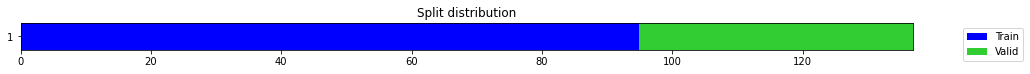

In [53]:
check_data(X, y, splits)

In [55]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:95, vars:24, len:144),
 tensor([10.8000, 10.5100, 13.5600, 21.6900, 16.5300, 16.2500, 11.0600, 11.6400,
         10.2600, 11.3200, 16.7700,  8.7500, 15.6800, 11.8300, 10.8200, 11.5400,
         17.3000, 22.7400, 11.9200, 14.9900, 21.9100, 16.0200, 11.4900, 11.9300,
         23.4200, 19.0100, 13.3700, 10.9200, 10.1100, 17.0000, 13.6900,  8.6200,
         19.3800, 17.5300, 11.2300, 14.0600, 18.5600, 12.0700, 20.4400, 10.5100,
         10.3100,  9.6300, 19.2200, 12.7200, 16.2200, 10.8900, 21.4900, 21.7400,
         14.2800, 12.0300,  5.3400, 11.5300, 14.6100, 10.6100, 17.6600, 14.7100,
         16.0500, 26.2800, 12.7800, 13.2900, 14.6200, 10.2500, 10.1700, 13.1000,
         18.1800, 21.3100, 12.6800, 12.9800,  9.6000, 12.2400, 13.8700, 19.6200,
         15.8900, 12.5400, 10.4600, 10.6200, 20.7400, 13.2500, 12.6800,  7.0300,
         23.0100, 12.9700, 11.6300, 11.4000, 10.6300,  9.9900, 16.4100,  5.3800,
         14.8200, 19.9400, 13.2100, 22.1000,  9.8200, 14.8000,  9.17

`TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [7]:
dls.c

1

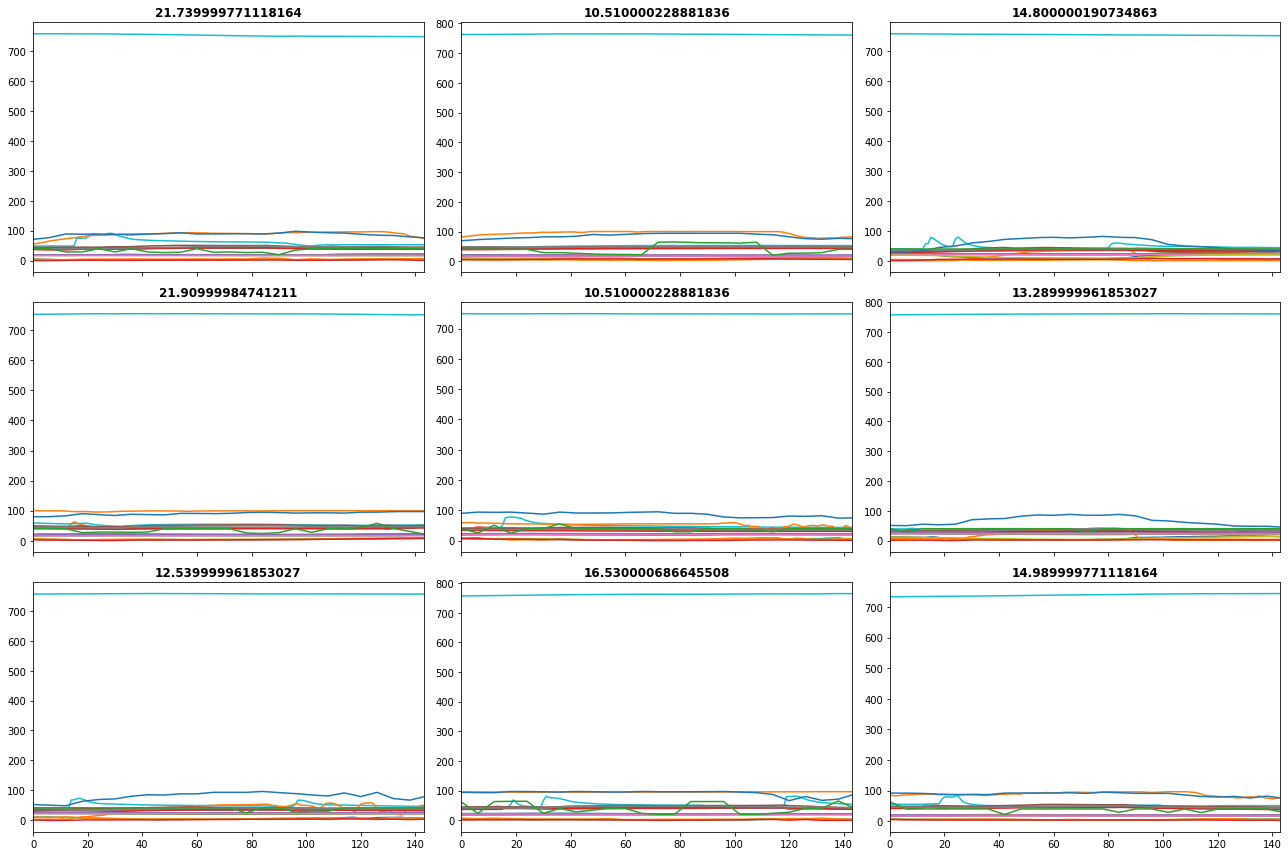

In [47]:
dls.show_batch()

## Build learner 🏗

* Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

In [69]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.015848932787775993)

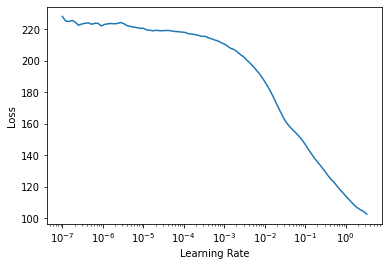

In [10]:
learn.lr_find()

It seems we can use a lr around 1e-2. Let's try it.

In [11]:
learn.loss_func

FlattenedLoss of MSELoss()

## Train model 🚵🏼‍

epoch,train_loss,valid_loss,mae,_rmse,time
0,215.656952,201.253830,13.761556,14.186396,00:00
1,212.435745,200.603119,13.737971,14.163443,00:00
2,209.185425,199.412476,13.694796,14.121349,00:00
3,205.469543,197.062546,13.609804,14.037897,00:00
4,201.237244,192.295303,13.439395,13.867058,00:00
5,196.540054,175.117630,12.800197,13.233201,00:00
6,191.528732,154.812775,12.006873,12.442377,00:00
7,186.437943,87.304169,8.897139,9.343671,00:00
8,180.661697,53.759312,6.736266,7.332074,00:00
9,174.402740,50.164062,6.402376,7.082659,00:00


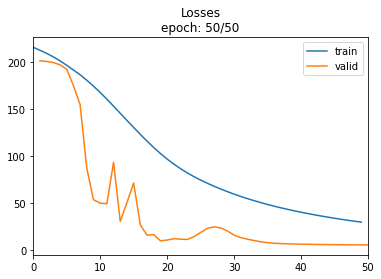

In [70]:
learn.fit_one_cycle(50, 1e-2)

## Predictions ⎘

In [71]:
valid_preds, valid_targets = learn.get_preds(ds_idx=1)
valid_preds.flatten().data, valid_targets.data

(tensor([15.0003, 15.1002, 11.1401,  9.3675, 12.7470, 13.3199, 19.7613, 13.3840,
         15.1831, 16.8271, 23.3448, 12.4885, 10.2032,  9.2419, 14.4385, 20.1090,
         14.2460, 12.2884, 11.6636, 13.6402, 12.5171, 17.8224, 12.6298,  9.4024,
         12.9872, 10.9085, 12.2852, 13.0340, 10.7474, 14.3865, 19.6082, 13.0848,
         13.7639, 14.7479, 12.3958, 12.6425,  9.4421, 15.2007, 17.6228, 10.3488,
         11.2633, 11.7312]),
 tensor([17.3700, 20.6500, 11.4200, 10.6800, 12.4400, 11.1700, 24.1200, 10.9900,
         13.7600, 14.5600, 14.9700, 13.4300, 11.5700,  9.3300, 15.5800, 20.9300,
         11.9900, 15.3700, 10.4700, 14.4100, 10.1600, 15.1200, 12.3200, 10.4600,
         15.0600,  9.6800, 10.6900, 17.8000, 10.6900, 17.0600, 20.8800, 10.8900,
         13.4700, 13.6200, 13.4800, 14.8900, 10.6000, 15.5900, 17.8900, 12.9500,
         10.1200, 12.1400]))

## Summary ✅

As you can see, to use fastai and timeseriesAI to perform a time series regression/ forecasting task is pretty easy. The only thing you need to make sure is that:

* Your data is correctly prepared (with ys as floats)
* Select the right metrics (Learner will automatically select the right loss, unless you want to pass a specific one yourself).